## Sampling From a Given Sigmoidal Cox Process

Use thinning procedure to sample from a sigmoidal cox process with gaussian intensity function as seen in 

- 'Adams, Ryan Prescott, Iain Murray, and David JC MacKay. "Tractable nonparametric Bayesian inference in Poisson processes with Gaussian process intensities." Proceedings of the 26th Annual International Conference on Machine Learning. ACM, 2009.'

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gpflow

In [114]:
def get_scp_samples(rate_function, region_lims, upper_bound):
    
    # region lims: np.array of shape (D x 2), D dimension of input space
    D = region_lims.shape[0]
    
    assert(np.alltrue(region_lims[:,0] <= region_lims[:,1])) # , 'First entries of regional limits need to be smaller or equal to the second entries')
    
    # 1. calc measure
    V = np.prod(np.absolute(region_lims[:,0] - region_lims[:,1]), axis=0)
    # 2. sample from poisson 
    J = np.random.poisson(V * upper_bound)
    # 3. sample locations uniformly
    low  = region_lims[:,0]
    high = region_lims[:,1]
    sample_candidates = np.random.uniform(low=low, high=high, size=(J, D))
    
    vals = rate_function(sample_candidates)
    
    # 5. iterate over points and accept/reject
    R = np.random.uniform(size=J) * upper_bound
    accept = R < vals # R < logistic(vals) * upper_bound
    
    return sample_candidates[accept], R[accept], sample_candidates, R

### a) 1d example
#### (i) Sinusoid

In [ ]:
def logistic(X):
    return 1. / (1. + np.exp(-X))

def ex_mean_fun(X):
    return np.squeeze(np.sin(X))
def ex_cov_fun(X):
    N = X.shape[0]
    return np.zeros((N, N))

def sin_rate_fun(X, upper_bound):
    mean_vals = ex_mean_fun(X)
    cov_vals  = ex_cov_fun(X)
    return logistic(np.random.multivariate_normal(mean_vals, cov_vals)) * upper_bound

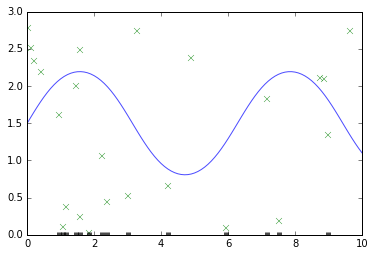

In [106]:
upper_bound = 3

accepted_samples, _, all_samples, R = get_scp_samples(lambda x: sin_rate_fun(x, upper_bound=upper_bound), np.array([[0,10]]), upper_bound = upper_bound)
X = np.linspace(0,10, 101)
y = sin_rate_fun(X, upper_bound)

plt.plot(X, y, alpha=.7)
plt.plot(all_samples, R , 'x', mew=.4)
plt.plot(accepted_samples, np.zeros(accepted_samples.shape[0]), 'k|', mew=5, alpha=.7)
plt.ylim(0, upper_bound)
plt.show()

#### (ii) GP prior

In [108]:
def ard_kernel_bc(X1, X2, gamma=1, alphas=None):
    if len(X1.shape) == 1:
        X1 = X1[:, None]
    if len(X2.shape) == 1:
        X2 = X2[:, None]
    assert(X1.shape[1] == X2.shape[1])
    
    if alphas is None:
        alphas = np.ones(X1.shape[1])
    return gamma * np.prod(np.exp(- (X1[:, None, :] - X2[None,:,:])**2 / (2 * alphas[None, None, :])), axis=2)

def zero_mean(X):
    return np.zeros(X.shape[0])

def gp_sample_rate_function(X, mean_fun=zero_mean, kernel_fun=ard_kernel_bc):
    mean = mean_fun(X)
    gram = kernel_fun(X, X)
    return np.random.multivariate_normal(mean, gram) ** 2

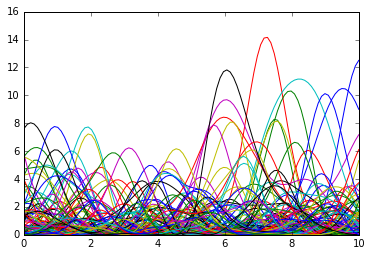

In [105]:
Tmin = 0
Tmax = 10
res  = 100
xs   = np.linspace(Tmin, Tmax, res)
num_samples = 100

plt_vals = []
for i in range(num_samples):
    ys = gp_sample_rate_function(xs, zero_mean, ard_kernel_bc)
    plt_vals.extend([xs, ys])

plt.plot(*plt_vals)
plt.show()

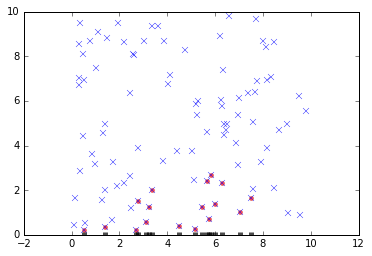

In [130]:
upper_bound = 10
space_lims  = [[0,10]]

accepted_samples, accepted_samples_R, all_samples, R = get_scp_samples(gp_sample_rate_function, np.array([[0,10]]), upper_bound = upper_bound)
# X = np.linspace(space_lims[0,0], space_lims[0,1], 101)
#y = 

# plt.plot(X, y, alpha=.7)
plt.plot(all_samples, R , 'x', mew=.4)
plt.plot(accepted_samples, np.zeros(accepted_samples.shape[0]), 'k|', mew=5, alpha=.7)

plt.scatter(accepted_samples, accepted_samples_R, c='r', alpha=.7, linewidth=0.1)

plt.ylim(0, upper_bound)
plt.show()

### b) 2d example

In [5]:
# TODO: add similar example for 2d input space